In [1]:
import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt; plt.rc('font', size=16)
import numpy as np
import os
import pandas as pd
from pathlib import Path

[DEBUG] Using default logger (stdout, stderr).


In [2]:
# Define useful lookup variables
cols = ['#016bff',
        '#b91f1c',
        '#308937',
        '#ff8137',
        '#6f4fc7',
        '#d4b300',
        '#893a2b',
        '#ff6c79',
        '#16c4ff',
        '#766f41',
        '#00c800',
        '#af3261']

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'}

order = ['B_cellulosilyticus_WH2', 
        'B_caccae', 
        'B_vulgatus', 
        'B_thetaiotaomicron', 
        'B_ovatus', 
        'R_obeum', 
        'B_uniformis', 
        'P_distasonis', 
        'C_scindens', 
        'C_aerofaciens', 
        'C_spiroforme', 
        'D_longicatena']

lf0 = ['1', '2', '3', '4', '5', '6', '7']
hf0 = ['8', '9', '10', '11', '12', '13', '14', '15']

taxa_color = {order: cols[i] for i, order in enumerate(order)}
taxa_color

{'B_cellulosilyticus_WH2': '#016bff',
 'B_caccae': '#b91f1c',
 'B_vulgatus': '#308937',
 'B_thetaiotaomicron': '#ff8137',
 'B_ovatus': '#6f4fc7',
 'R_obeum': '#d4b300',
 'B_uniformis': '#893a2b',
 'P_distasonis': '#ff6c79',
 'C_scindens': '#16c4ff',
 'C_aerofaciens': '#766f41',
 'C_spiroforme': '#00c800',
 'D_longicatena': '#af3261'}

In [3]:
def filter_sims(x):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if (x[i,j].max() > 1e10) | (x[i,j].min() < 1e3):
                x[i,j] = np.nan
    return x

In [4]:
def plot_forward_sims_by_ind(dataset, taxa2plot='all', true_data=True, filt_data=False, save=False):
    if dataset == 'LF0':
        subjs = lf0
    elif dataset == 'HF0':
        subjs = hf0
    else:
        raise ValueError(f'Unknown dataset: {dataset}')
    study = md2.Study.load(f'mcnulty-datasets/{dataset}/mcnulty_{dataset}.pkl')
    true_abundances = [study[subj].matrix()['abs'] for subj in subjs]
    times = [study[subj].times for subj in subjs]
    taxa = [list(study[subj].taxa.names.keys()) for subj in subjs]
    fwsim = [np.load(f'mcnulty-results/{dataset}/forward-simulate/Subject_{subj}/fwsim.npy') for subj in subjs]
    fwsim_filt = [filter_sims(fwsim[subj]) for subj in range(len(subjs))]
    start = 0
    step = 0.01
    end = 40
    sim_times = np.arange(start, end+step+step, step)
    if filt_data:
        filt = [pd.read_table(f'mcnulty-results/{dataset}/posteriors/filtering/Subject_{subj}/median.tsv', index_col=0) for subj in subjs]
        filt_times = [filt[subj].T.index.values.astype(float) for subj in range(len(subjs))]
    fig, axs = plt.subplots(4, 2, figsize=(20, 20))
    row = 0
    col = 0
    for subj in range(len(subjs)):
        if taxa2plot == 'all':
            taxa2plot = taxa[subj]
        for i, j in enumerate(taxa[subj]):
            if j in taxa2plot:
                taxon = i
            else:
                continue
            if true_data:
                axs[row,col].plot(times[subj], true_abundances[subj][taxon,:], color=taxa_color[taxa[subj][taxon]], marker='x', linestyle=':')
            if filt_data:
                axs[row,col].plot(filt_times[subj], filt[subj].T[taxa[subj][taxon]], color=taxa_color[taxa[subj][taxon]], marker='.', linestyle='--')
            fwsim_mean = np.nanmean(fwsim_filt[subj], axis=0)[taxon]
            fwsim_std = np.nanstd(fwsim_filt[subj], axis=0)[taxon]
            axs[row,col].plot(sim_times, fwsim_mean, color=taxa_color[taxa[subj][taxon]], linewidth=2, label=f'{taxa[subj][taxon]}')
            axs[row,col].fill_between(sim_times, fwsim_mean-fwsim_std, fwsim_mean+fwsim_std, color=taxa_color[taxa[subj][taxon]], alpha=0.2)
        if dataset == 'LF0':
            axs[row,col].fill_between(x=[14,26], y1=1, y2=1e12, color='grey', alpha=0.2)
        elif dataset == 'HF0':
            axs[row,col].fill_between(x=[0,14], y1=1, y2=1e12, color='grey', alpha=0.2)
            axs[row,col].fill_between(x=[26,40], y1=1, y2=1e12, color='grey', alpha=0.2)
        axs[row,col].set_title(f'Subject {subjs[subj]}')
        axs[row,col].set_yscale('log')
        axs[row,col].set_ylim([1e4, 1e9])
        fig.suptitle(f'Forward Simulation of species trajectories for subjects in {dataset} dataset', y=0.92)
        fig.supxlabel('Time (days)', y=0.075)
        fig.supylabel('$\log_{10}$ Abundance', x=0.075)
        handles, labels = axs[0,0].get_legend_handles_labels()
        pretty_labels = [x if x not in pretty_names_dir else pretty_names_dir[x] for x in labels]
        fig.legend(handles, pretty_labels, loc='lower center', ncol=4)
        col += 1
        if col == 2:
            col = 0
            row += 1
    if save:
        fig.savefig(f'mcnulty-results/{dataset}/forward-simulate/{dataset}_forward_simulations.pdf', bbox_inches='tight')
    else:
        return fig, axs

In [5]:
plot_forward_sims_by_ind(dataset='LF0', taxa2plot='all', true_data=True, filt_data=False, save=False)
plt.show()

: 

: 

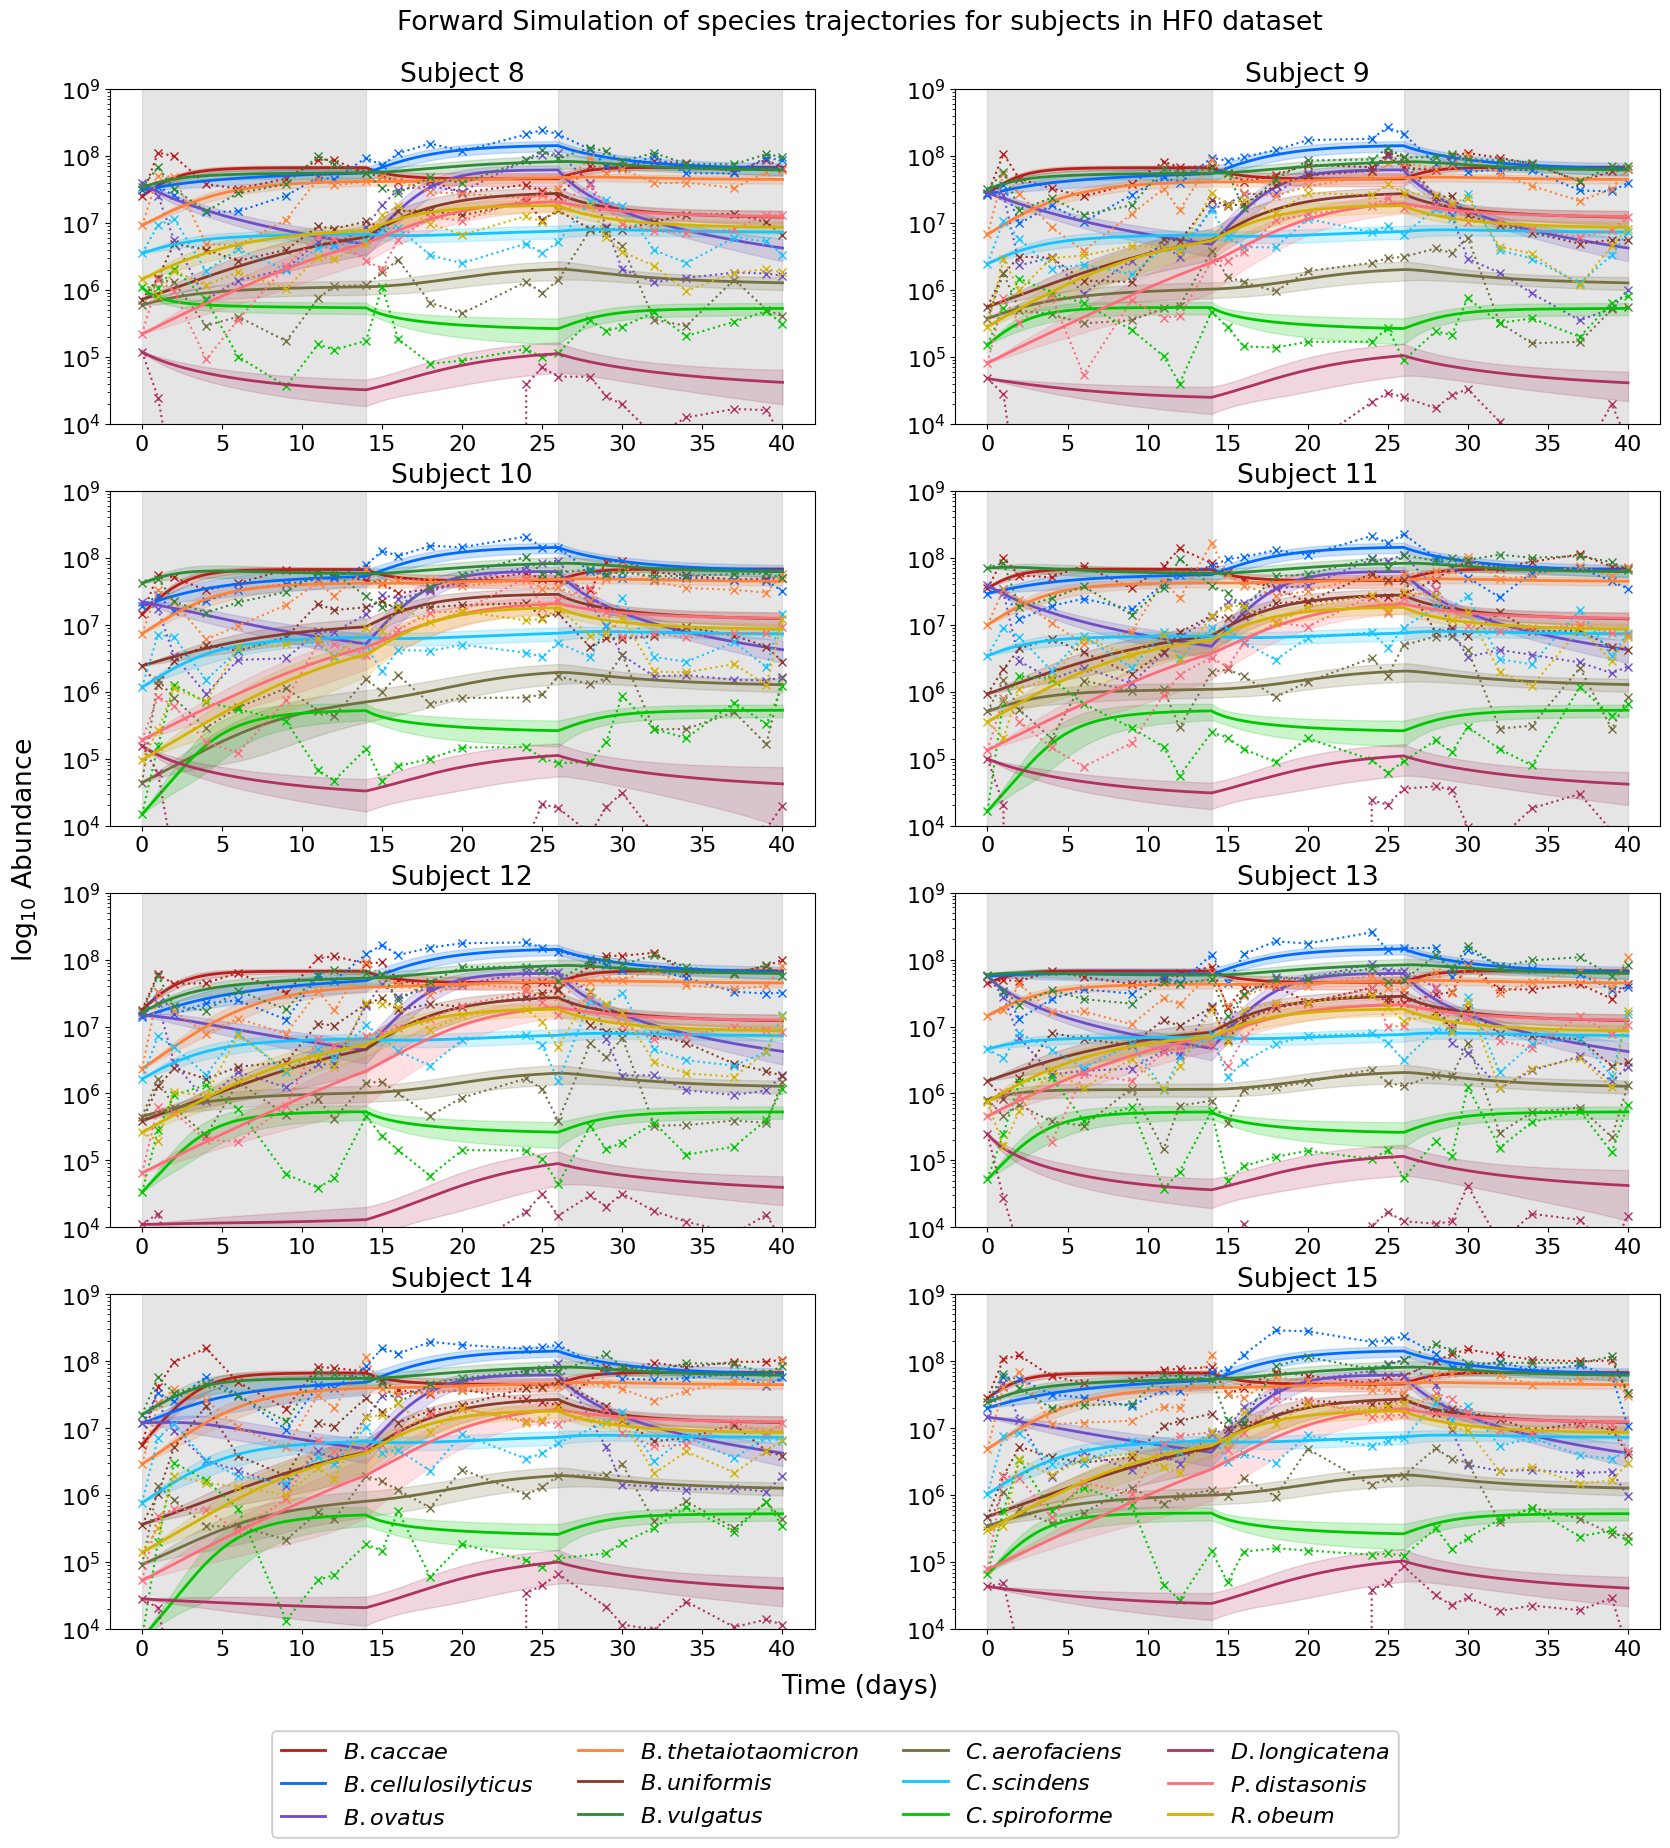

In [ ]:
plot_forward_sims_by_ind(dataset='HF0', taxa2plot='all', true_data=True, filt_data=False, save=False)
plt.show()

In [ ]:
a = np.load(f'mcnulty-results/LF0/forward-simulate/Subject_1/fwsim.npy')
b = np.load(f'mcnulty-results/LF0/forward-simulate/Subject_2/fwsim.npy')

In [ ]:
a.shape

(2400, 12, 4002)

In [ ]:
c = np.concatenate([a,b])
c.shape

(4800, 12, 4002)

In [ ]:
def plot_forward_sims_for_inds(dataset, taxa2plot='all', true_data=True, filt_data=False, save=False):
    if dataset == 'LF0':
        subjs = lf0
    elif dataset == 'HF0':
        subjs = hf0
    else:
        raise ValueError(f'Unknown dataset: {dataset}')
    study = md2.Study.load(f'mcnulty-datasets/{dataset}/mcnulty_{dataset}.pkl')
    true_abundances = [study[subj].matrix()['abs'] for subj in subjs]
    times = [study[subj].times for subj in subjs]
    taxa = [list(study[subj].taxa.names.keys()) for subj in subjs]
    fwsim = [np.load(f'mcnulty-results/{dataset}/forward-simulate/Subject_{subj}/fwsim.npy') for subj in subjs]
    fwsim_filt = [filter_sims(fwsim[subj]) for subj in range(len(subjs))]
    start = 0
    step = 0.01
    end = 40
    sim_times = np.arange(start, end+step+step, step)
    # Aggregate
    taxa = taxa[0]
    fwsim_filt_agg = np.concatenate(fwsim_filt)
    if filt_data:
        filt = [pd.read_table(f'mcnulty-results/{dataset}/posteriors/filtering/Subject_{subj}/median.tsv', index_col=0) for subj in subjs]
        filt_times = [filt[subj].T.index.values.astype(float) for subj in range(len(subjs))]
    fig, ax = plt.subplots(figsize=(10, 10))
    if taxa2plot == 'all':
        taxa2plot = taxa
    for i, j in enumerate(taxa):
        if j in taxa2plot:
            taxon = i
        else:
            continue
        if true_data:
            for subj in range(len(subjs)):
                ax.plot(times[subj], true_abundances[subj][taxon,:], color=taxa_color[taxa[subj][taxon]], marker='x', linestyle=':')
        if filt_data:
            for subj in range(len(subjs)):
                ax.plot(filt_times[subj], filt[subj].T[taxa[subj][taxon]], color=taxa_color[taxa[subj][taxon]], marker='.', linestyle='--')
        fwsim_mean = np.nanmean(fwsim_filt_agg, axis=0)[taxon]
        fwsim_std = np.nanstd(fwsim_filt_agg, axis=0)[taxon]
        ax.plot(sim_times, fwsim_mean, color=taxa_color[taxa[taxon]], linewidth=2, label=f'{taxa[taxon]}')
        ax.fill_between(sim_times, fwsim_mean-fwsim_std, fwsim_mean+fwsim_std, color=taxa_color[taxa[taxon]], alpha=0.2)
    if dataset == 'LF0':
        ax.fill_between(x=[14,26], y1=1, y2=1e12, color='grey', alpha=0.2)
    elif dataset == 'HF0':
        ax.fill_between(x=[0,14], y1=1, y2=1e12, color='grey', alpha=0.2)
        ax.fill_between(x=[26,40], y1=1, y2=1e12, color='grey', alpha=0.2)
    ax.set_yscale('log')
    ax.set_ylim([1e4, 1e9])
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$\log_{10}$ Abundance')
    handles, labels = ax.get_legend_handles_labels()
    ax.set_title(f'Forward Simulation of species trajectories for subjects in {dataset} dataset')
    handles, labels = ax.get_legend_handles_labels()
    pretty_labels = [x if x not in pretty_names_dir else pretty_names_dir[x] for x in labels]
    ax.legend(handles, pretty_labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=12)
    if save:
        fig.savefig(f'mcnulty-results/{dataset}/forward-simulate/{dataset}_forward_simulations.pdf', bbox_inches='tight')
    else:
        return fig, ax

In [ ]:
plot_forward_sims_for_inds(dataset='LF0', taxa2plot='all', true_data=False, filt_data=False, save=False)
plt.show()

: 

: 

In [ ]:
# def plot_data_pred_mean_area(study_path, dataset, fwsim_path, seed=0, save=True):
#     if dataset == 'LF0':
#         subjs = lf0
#     elif dataset == 'HF0':
#         subjs = hf0
#     else:
#         raise ValueError(f'Unknown dataset: {dataset}')
#     study = md2.Study.load(f'{study_path}/{dataset}/mcnulty_{dataset}.pkl')
#     taxa = [list(study[subj].taxa.names.keys()) for subj in subjs]
#     fwsim = [np.load(f'{fwsim_path}/mcnulty_{dataset}_seed{seed}/posteriors/forward_simulation/Subject_{subj}/median.tsv') for subj in subjs]
#     fwsim_mean = np.mean([fwsim[subj].mean(axis=0) for subj in subjs], axis=0)
#     area = pd.DataFrame(fwsim_mean.T, columns=taxa[0], index=np.arange(fwsim_mean.shape[1]))
#     area.index = area.index*0.01
#     area.plot.area(stacked=True, 
#         color=cols, 
#         rot=0, 
#         linewidth=0.3,
#         ylim=(1e5, 5.2e8))
#     if dataset == 'LF0':
#         plt.fill_between(x=[14,26], y1=1, y2=1e12, color='grey', alpha=0.2)
#     elif dataset == 'HF0':
#         plt.fill_between(x=[0,12], y1=1, y2=1e12, color='grey', alpha=0.2)
#         plt.fill_between(x=[28,40], y1=1, y2=1e12, color='grey', alpha=0.2)
#     plt.title(f'{dataset} abundance as a function of time')
#     plt.yscale('log')
#     plt.ylim(1e4, 1e10)
#     plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
#     plt.xlabel('Time (Days)')
#     plt.ylabel('$Log_{10}$ Abundance')
#     if save:
#         plt.savefig(f'{fwsim_path}/mcnulty_{dataset}_seed{seed}/posteriors/Sims.pdf', bbox_inches='tight')
#         plt.close()
#     else:
#         plt.show()